In [42]:
import snowflake.connector
import pandas as pd
import seaborn as sns
import plotly.express as px
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
usr = os.environ['svc_user']
pwd = os.environ['svc_pwd']

warnings.filterwarnings('ignore')

In [43]:
def sf_connect():
    con = snowflake.connector.connect(  
        account = 'chewy.us-east-1',
        user = usr,
        password=pwd,
        autocommit = False,
        database= 'EDLDB',
        warehouse = 'IT_WH') #EDLDB_DSE_DEV
    return con

In [44]:
def exec_qry_all(qry):
    con = sf_connect()
    cur = con.cursor()
    try:
        cur.execute(qry,timeout=1200)
        return cur.fetch_pandas_all()   
    except Exception as e:
        print(e)
    finally:
        cur.close()

---

In [45]:
qry = """SELECT * FROM EDLDB.ECOM_SANDBOX.CTR_TEMP_ZONE10_SV"""
qry1 = """SELECT * FROM ECOM_SANDBOX.CMS_BASE_SEG_SV"""

In [46]:
df = exec_qry_all(qry)

---

##### Testing

In [47]:
test_data = df[(df['WIDGET_NAME'] == 'homepage-zone-10-body-10-promo-standard-nonsku-collection')&(df['CMS_LEVEL'] == 'asset')]
len(test_data)
test_data.head()

,SESSIONS_DATE_EST,CHEWY_FINANCIAL_REPORTING_PERIOD,DEVICE_CATEGORY,CMS_LEVEL,PLACEMENT_SLOT_UID,WIDGET_POSITION,WIDGET_TYPE,WIDGET_TYPE_VALUE,ZONE,WIDGET_NAME,...,ASSET_SEGMENT_VIEWS,WIDGET_SEGMENT_CLICKS,ASSET_SEGMENT_CLICKS,PAGE_IMPRESSIONS,ATTRIBUTED_REVENUE,ATTRIBUTED_UNITS,ATTRIBUTED_ORDER,AUTOSHIP_ATTRIBUTED_REVENUE,AUTOSHIP_ATTRIBUTED_UNITS,AUTOSHIP_ATTRIBUTED_ORDER
6,2022-02-11,2022-P01,None,asset,3,3,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,30.0,NaN,0.0,NaN,0.00,0.0,0.0,0.00,0.0,0.0
11,2022-02-12,2022-P01,mobile,asset,2,2,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,993.0,NaN,32.0,NaN,236.96,13.0,5.5,36.28,3.0,1.5
22,2022-02-11,2022-P01,desktop,asset,4,4,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,54.0,NaN,0.0,NaN,0.00,0.0,0.0,0.00,0.0,0.0
40,2022-02-12,2022-P01,mobile,asset,2,2,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,102.0,NaN,1.0,NaN,0.00,0.0,0.0,0.00,0.0,0.0
42,2022-02-17,2022-P01,desktop,asset,3,3,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,514.0,NaN,1.0,NaN,0.00,0.0,0.0,0.00,0.0,0.0


In [56]:
int(max(test_data['ASSET_SEGMENT_CLICKS']))

14507

In [7]:
a = list(test_data.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean())
a = [x / sum(a) for x in a]
b = list(test_data.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean().index)
test_dict = dict(zip(b,a))
#print(np.asarray((a, b)).T)
test_dict

{'hp-bird': 0.13640480028337942,
 'hp-cat': 0.19033613831251409,
 'hp-dog': 0.19049554396794505,
 'hp-farm-animal': 0.01726720874731805,
 'hp-fish': 0.134111177313557,
 'hp-horse': 0.01853451786874341,
 'hp-pet-parents': 0.015159650553607792,
 'hp-reptile': 0.1282120344119857,
 'hp-small-pet': 0.16947892854094948}

In [8]:
test_data['prob'] = test_data['CREATIVE_NAME'].map(test_dict)

In [9]:
test_data[['CREATIVE_NAME','prob']].head(20)

,CREATIVE_NAME,prob
1,hp-farm-animal,0.017267
2,hp-bird,0.136405
3,hp-cat,0.190336
4,hp-fish,0.134111
11,hp-farm-animal,0.017267
14,hp-reptile,0.128212
15,hp-small-pet,0.169479
21,hp-reptile,0.128212
22,hp-reptile,0.128212
30,hp-bird,0.136405


In [10]:
x = np.random.choice(b, 1, p=a)
x

array(['hp-fish'], dtype='<U14')

In [11]:
test_data.sample(n=10, weights='prob', random_state=1)['CREATIVE_NAME']

304          hp-bird
1556          hp-dog
3             hp-cat
649          hp-fish
1310         hp-bird
2152          hp-dog
12      hp-small-pet
2000          hp-cat
742       hp-reptile
335           hp-dog
Name: CREATIVE_NAME, dtype: object

---

Without function

In [12]:
df = df[(df['WIDGET_NAME'] == 'homepage-zone-10-body-10-promo-standard-nonsku-collection')&(df['CMS_LEVEL'] == 'asset')]

df['CTR'] = (df['ASSET_SEGMENT_CLICKS']/df['ASSET_SEGMENT_VIEWS']*100).round(2)
df['CTR'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['CTR'] = df['CTR'].fillna(0)

df['UNITS/K'] = ((df['ATTRIBUTED_UNITS']/df['ASSET_SEGMENT_VIEWS'])*1000).round(2)
df['UNITS/K'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['UNITS/K'] = df['UNITS/K'].fillna(0)

In [13]:
df[['CREATIVE_NAME',"CTR",'UNITS/K']]

,CREATIVE_NAME,CTR,UNITS/K
1,hp-farm-animal,12.77,14.18
2,hp-bird,0.00,0.00
3,hp-cat,3.07,12.43
4,hp-fish,5.87,5.71
11,hp-farm-animal,0.00,0.00
...,...,...,...
226,hp-dog,0.00,0.00
244,hp-bird,0.00,0.00
247,hp-reptile,8.82,29.41
248,hp-horse,16.67,23.81


Re-ordering with CTR and UNIT/K by random sampling <br>
Getting 1000 random samples of 50% size

In [14]:
a = list(df.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean())
a = [np.round(x / sum(a),3) for x in a]
b = list(df.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean().index)
test_dict = dict(zip(b,a))
test_dict

{'hp-bird': 0.136,
 'hp-cat': 0.19,
 'hp-dog': 0.19,
 'hp-farm-animal': 0.017,
 'hp-fish': 0.134,
 'hp-horse': 0.019,
 'hp-pet-parents': 0.015,
 'hp-reptile': 0.128,
 'hp-small-pet': 0.169}

In [15]:
df['PROB'] = df['CREATIVE_NAME'].map(test_dict)
df[['CREATIVE_NAME','PROB']]

,CREATIVE_NAME,PROB
1,hp-farm-animal,0.017
2,hp-bird,0.136
3,hp-cat,0.190
4,hp-fish,0.134
11,hp-farm-animal,0.017
...,...,...
226,hp-dog,0.190
244,hp-bird,0.136
247,hp-reptile,0.128
248,hp-horse,0.019


In [16]:
#df.sample(n=10, weights='PROB', random_state=1)

In [17]:
df_ctr = df[['CREATIVE_NAME','PROB','CTR']]
resamples_ctr = [df_ctr.sample(n=5000, weights='PROB') for i in range(1000)]
sol_ctr = []

df_units = df[['CREATIVE_NAME','PROB','UNITS/K']]
resamples_units = [df_units.sample(n=5000, weights='PROB') for i in range(1000)]
sol_units = []

In [18]:
resamples_ctr[0]['CREATIVE_NAME'].value_counts()

hp-cat            1136
hp-dog            1098
hp-small-pet       928
hp-bird            662
hp-fish            588
hp-reptile         535
hp-horse            25
hp-pet-parents      18
hp-farm-animal      10
Name: CREATIVE_NAME, dtype: int64

In [19]:
#resamples_ctr[2]['CREATIVE_NAME'].value_counts()

In [20]:
for i in range(1000): 
    resamples_ctr[i] = resamples_ctr[i].groupby('CREATIVE_NAME').agg({'CTR':'mean'})
    resamples_ctr[i] = resamples_ctr[i].sort_values('CTR', ascending = False)
    sol_ctr.append(list(resamples_ctr[i].index)) #list of 1000 lists having asset order

    resamples_units[i] = resamples_units[i].groupby('CREATIVE_NAME').agg({'UNITS/K':'mean'})
    resamples_units[i] = resamples_units[i].sort_values('UNITS/K', ascending = False)
    sol_units.append(list(resamples_units[i].index))


In [21]:
print(resamples_ctr[0])
print(resamples_units[0])

                      CTR
CREATIVE_NAME            
hp-pet-parents  12.386667
hp-farm-animal   7.426000
hp-horse         3.613600
hp-cat           3.530343
hp-dog           2.859572
hp-fish          0.551837
hp-reptile       0.521271
hp-bird          0.314230
hp-small-pet     0.187769
                   UNITS/K
CREATIVE_NAME             
hp-horse        118.114615
hp-cat           23.539219
hp-dog           19.517312
hp-pet-parents    3.679412
hp-reptile        1.954738
hp-fish           1.007468
hp-farm-animal    0.678947
hp-bird           0.511576
hp-small-pet      0.088792


In [36]:
sum_ctr,sum_units,sum_result,asset_ordered = [],[],[],[]
# unique_assets = df['CREATIVE_NAME'].unique()
unique_assets = sol_ctr[0]
for j in range(len(unique_assets)):
#for j in range(len(df['CREATIVE_NAME'].unique())): #j=0-9
    sum_ctr.append(0)
    sum_units.append(0)
    for i in range(1000): #i=0-1000
        sum_ctr[j] = sum_ctr[j] + sol_ctr[i].index(unique_assets[j])+1
        sum_units[j] = sum_units[j] + sol_units[i].index(unique_assets[j])+1
        
    sum_result.append(np.round((sum_ctr[j]*0.3)+(sum_units[j]*0.7),1))
    test_avg = [np.round((x / 1000),2) for x in sum_result]

# print('Unsorted CTR:',sum_ctr)
# print('Unsorted UNIT/K:',sum_units)
#print(pd.DataFrame(zip(unique_assets,test_avg), columns=['Asset Name', 'Combined Score']))

# avg_ctr = [np.round((x / 1000),2) for x in sum_ctr]
# avg_units = [np.round((x / 1000),2) for x in sum_units]
# avg_combined = [np.round((x / 1000),2) for x in sum_result]

pos_ctr = dict(zip(sum_ctr, df['CREATIVE_NAME'].unique()))
pos_units = dict(zip(sum_units, df['CREATIVE_NAME'].unique()))
pos_dict = dict(zip(sum_result, df['CREATIVE_NAME'].unique()))

#print('Sorted combined:',sum_result)
sum_result.sort()
for i in sum_result:
    asset_ordered.append(pos_dict[i])
print('Re-ordered assets:',asset_ordered)

key_ctr = list(pos_ctr.keys())
val_ctr = list(pos_ctr.values())
avg_ctr = []
for i in asset_ordered:
    position = val_ctr.index(i)
    avg_ctr.append(np.round(key_ctr[position]/1000,2))

key_units = list(pos_units.keys())
val_units = list(pos_units.values())
avg_units = []
for i in asset_ordered:
    position = val_units.index(i)
    avg_units.append(np.round(key_units[position]/1000,2))

avg_combined = [np.round((x / 1000),2) for x in sum_result]
pd.DataFrame(list(zip(asset_ordered,avg_ctr,avg_units,avg_combined)),columns= ['Re-ordered Assets','Avg CTR','Avg Units/K','Avg combined score'])

Re-ordered assets: ['hp-fish', 'hp-reptile', 'hp-cat', 'hp-farm-animal', 'hp-bird', 'hp-small-pet', 'hp-dog', 'hp-pet-parents', 'hp-horse']


,Re-ordered Assets,Avg CTR,Avg Units/K,Avg combined score
0,hp-fish,3.30,1.54,2.06
1,hp-reptile,4.15,2.12,2.73
2,hp-cat,1.97,4.88,4.01
3,hp-farm-animal,1.67,5.17,4.12
4,hp-bird,4.17,5.82,5.33
5,hp-small-pet,6.85,5.62,5.99
6,hp-dog,6.22,6.09,6.13
7,hp-pet-parents,7.70,5.68,6.28
8,hp-horse,8.97,8.08,8.35


---

### Main code <br>
With function

In [23]:
qry_test = """SELECT * FROM EDLDB.ECOM_SANDBOX.CTR_TEMP_SV_ZONE_ALL"""
qry = """SELECT * FROM EDLDB.ECOM_SANDBOX.CTR_TEMP_ZONE10_SV"""

In [24]:
dataset = exec_qry_all(qry_test)
dataset.head()

,SESSIONS_DATE_EST,CHEWY_FINANCIAL_REPORTING_PERIOD,DEVICE_CATEGORY,CMS_LEVEL,PLACEMENT_SLOT_UID,WIDGET_POSITION,WIDGET_TYPE,WIDGET_TYPE_VALUE,ZONE,WIDGET_NAME,...,ASSET_SEGMENT_VIEWS,WIDGET_SEGMENT_CLICKS,ASSET_SEGMENT_CLICKS,PAGE_IMPRESSIONS,ATTRIBUTED_REVENUE,ATTRIBUTED_UNITS,ATTRIBUTED_ORDER,AUTOSHIP_ATTRIBUTED_REVENUE,AUTOSHIP_ATTRIBUTED_UNITS,AUTOSHIP_ATTRIBUTED_ORDER
0,2022-02-11,2022-P01,desktop,widget,cat-ban-10-315,10,banner,category-banner,None,315-null-null-10-banner,...,NaN,0.0,NaN,34.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-14,2022-P01,mobile,asset,371642866672489,20,grid,circle-tiles,None,autoship-save-body-20-grid,...,1.0,NaN,0.0,NaN,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2022-02-13,2022-P01,desktop,asset,2-10,None,standard-sku-collection,None,None,356-chewychoice-body-10-promo-standard-sku-col...,...,89.0,NaN,5.0,NaN,226.92,10.500000,1.500000,0.000000,0.000000,0.000000
3,2022-02-12,2022-P01,desktop,widget,None,None,standard-banner,None,None,1415-dog-oral-treatments-body-10-promo-banner,...,NaN,0.0,NaN,NaN,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,2022-02-17,2022-P01,desktop,asset,brand-banner-10-all,10,tiles,homepage-brand-tiles,None,home-1000-plus-brands,...,729.0,NaN,25.0,NaN,242.14,36.928574,2.392859,10.710714,0.357145,0.357145


In [39]:
def asset_reordering(widget_name, start_date = '2022-02-10', end_date = '2022-02-17'):
    #Filter by widget, date range and calculate CTR, UNIT/K
    df = dataset[(dataset['WIDGET_NAME'] == widget_name)&(dataset['CMS_LEVEL'] == 'asset')]
    df['SESSIONS_DATE_EST'] = df['SESSIONS_DATE_EST'].astype(str)
    df = df[(df['SESSIONS_DATE_EST'] >= start_date)&(df['SESSIONS_DATE_EST'] <= end_date)]
    print("Date Range: {} - {}".format(df['SESSIONS_DATE_EST'].min(),df['SESSIONS_DATE_EST'].max()))

    df['CTR'] = (df['ASSET_SEGMENT_CLICKS']/df['ASSET_SEGMENT_VIEWS']*100).round(2)
    df['CTR'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['CTR'] = df['CTR'].fillna(0)

    df['UNITS/K'] = ((df['ATTRIBUTED_UNITS']/df['ASSET_SEGMENT_VIEWS'])*1000).round(2)
    df['UNITS/K'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['UNITS/K'] = df['UNITS/K'].fillna(0)

    #Calculate mean impressions by assets
    asset_impressions = list(df.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean())
    asset_impressions = [x / sum(asset_impressions) for x in asset_impressions] #Calculate probability score of impressions by assets
    asset_names = list(df.groupby(['CREATIVE_NAME'])['ASSET_SEGMENT_VIEWS'].mean().index)
    asset_dict = dict(zip(asset_names,asset_impressions))

    #Create probability column to sample assets by probability score
    df['PROB'] = df['CREATIVE_NAME'].map(asset_dict)

    #Resample by CTR and UNIT/K
    df_ctr = df[['CREATIVE_NAME','PROB','CTR']]
    resamples_ctr = [df_ctr.sample(n=5000, weights='PROB', replace = True) for i in range(1000)]
    sol_ctr = []

    df_units = df[['CREATIVE_NAME','PROB','UNITS/K']]
    resamples_units = [df_units.sample(n=5000, weights='PROB', replace = True) for i in range(1000)]
    sol_units = []

    #Sort all 1000 samples for CTR and UNIT/K and append to lists
    for i in range(1000): 
        resamples_ctr[i] = resamples_ctr[i].groupby('CREATIVE_NAME').agg({'CTR':'mean'})
        resamples_ctr[i] = resamples_ctr[i].sort_values('CTR', ascending = False)
        sol_ctr.append(list(resamples_ctr[i].index)) #list of 1000 lists having asset order

        resamples_units[i] = resamples_units[i].groupby('CREATIVE_NAME').agg({'UNITS/K':'mean'})
        resamples_units[i] = resamples_units[i].sort_values('UNITS/K', ascending = False)
        sol_units.append(list(resamples_units[i].index))

    #Calculate sums for each asset and calculate combined metric sums
    sum_ctr,sum_units,sum_result,asset_ordered = [],[],[],[]
    unique_assets = df['CREATIVE_NAME'].unique()
    for j in range(len(df['CREATIVE_NAME'].unique())):
        sum_ctr.append(0)
        sum_units.append(0)
        for i in range(1000):
            sum_ctr[j] = sum_ctr[j] + sol_ctr[i].index(unique_assets[j])+1
            sum_units[j] = sum_units[j] + sol_units[i].index(unique_assets[j])+1
        #Get a combined metric value by weughting ctr - 30% and units/k - 70%   
        sum_result.append(np.round((sum_ctr[j]*0.3)+(sum_units[j]*0.7),1))
        test_var = [np.round((x / 1000),2) for x in sum_result]

    # print('Unsorted CTR:',sum_ctr)
    # print('Unsorted UNIT/K:',sum_unitss)
    # print("Unsorted combined:",sum_result
    print(pd.DataFrame(zip(unique_assets,test_var), columns=['Asset Name', 'Combined Score']))

    #Dictionary to point sum values to asset names
    pos_ctr = dict(zip(sum_ctr, df['CREATIVE_NAME'].unique()))
    pos_units = dict(zip(sum_units, df['CREATIVE_NAME'].unique()))
    pos_combined = dict(zip(sum_result, df['CREATIVE_NAME'].unique()))

    #Sort and print out re-ordered assets
    sum_result.sort()
    for i in sum_result:
        asset_ordered.append(pos_combined[i])
    # print('Re-ordered assets:',asset_ordered)

    # Get a list of avg ctr for all ordered assets
    key_ctr = list(pos_ctr.keys())
    val_ctr = list(pos_ctr.values())
    avg_ctr = []
    for i in asset_ordered:
        position = val_ctr.index(i)
        avg_ctr.append(np.round(key_ctr[position]/1000,2))

    # Get a list of avg units/k for all ordered assets
    key_units = list(pos_units.keys())
    val_units = list(pos_units.values())
    avg_units = []
    for i in asset_ordered:
        position = val_units.index(i)
        avg_units.append(np.round(key_units[position]/1000,2))

    # Get a list of avg values for the combined metric for all ordered assets
    avg_combined = [np.round((x / 1000),2) for x in sum_result]
    assets = pd.DataFrame(list(zip(asset_ordered,avg_ctr,avg_units,avg_combined)),columns= ['Re-ordered Assets','Avg CTR','Avg Units/K','Avg combined score'])

    return assets

In [40]:
asset_reordering('homepage-zone-10-body-10-promo-standard-nonsku-collection', '2022-02-10', '2022-02-17')

Date Range: 2022-02-10 - 2022-02-17
       Asset Name  Combined Score
0          hp-cat            2.11
1          hp-dog            2.60
2    hp-small-pet            8.09
3      hp-reptile            6.08
4         hp-fish            5.87
5         hp-bird            6.19
6  hp-pet-parents            4.46
7        hp-horse            4.20
8  hp-farm-animal            5.38


,Re-ordered Assets,Avg CTR,Avg Units/K,Avg combined score
0,hp-cat,3.24,1.63,2.11
1,hp-dog,3.92,2.04,2.60
2,hp-horse,2.11,5.10,4.20
3,hp-pet-parents,1.88,5.57,4.46
4,hp-farm-animal,4.31,5.84,5.38
5,hp-fish,6.86,5.45,5.87
6,hp-reptile,6.24,6.01,6.08
7,hp-bird,7.55,5.60,6.19
8,hp-small-pet,8.89,7.75,8.09


---

---

### EXTRA CODE

##### Unoptimized combined metric re-ordering

In [27]:
res_ctr = []
sum_pet_parents,sum_horse,sum_farm_animal,sum_cat,sum_dog,sum_fish,sum_reptile,sum_bird,sum_small_pet = 0,0,0,0,0,0,0,0,0

res_unit = []
sum_pet_parents_unit,sum_horse_unit,sum_farm_animal_unit,sum_cat_unit,sum_dog_unit,sum_fish_unit,sum_reptile_unit,sum_bird_unit,sum_small_pet_unit = 0,0,0,0,0,0,0,0,0

result = []
for i in range(1000):
    sum_pet_parents = sum_pet_parents + sol_ctr[i].index('hp-pet-parents')+1
    sum_horse = sum_horse + sol_ctr[i].index('hp-horse')+1
    sum_farm_animal = sum_farm_animal + sol_ctr[i].index('hp-farm-animal')+1
    sum_cat = sum_cat + sol_ctr[i].index('hp-cat')+1
    sum_dog = sum_dog + sol_ctr[i].index('hp-dog')+1
    sum_fish = sum_fish + sol_ctr[i].index('hp-fish')+1
    sum_reptile = sum_reptile + sol_ctr[i].index('hp-reptile')+1
    sum_bird = sum_bird + sol_ctr[i].index('hp-bird')+1
    sum_small_pet = sum_small_pet + sol_ctr[i].index('hp-small-pet')+1

    sum_pet_parents_unit = sum_pet_parents_unit + sol_units[i].index('hp-pet-parents')+1
    sum_horse_unit = sum_horse_unit + sol_units[i].index('hp-horse')+1
    sum_farm_animal_unit = sum_farm_animal_unit + sol_units[i].index('hp-farm-animal')+1
    sum_cat_unit = sum_cat_unit + sol_units[i].index('hp-cat')+1
    sum_dog_unit = sum_dog_unit + sol_units[i].index('hp-dog')+1
    sum_fish_unit = sum_fish_unit + sol_units[i].index('hp-fish')+1
    sum_reptile_unit = sum_reptile_unit + sol_units[i].index('hp-reptile')+1
    sum_bird_unit = sum_bird_unit + sol_units[i].index('hp-bird')+1
    sum_small_pet_unit = sum_small_pet_unit + sol_units[i].index('hp-small-pet')+1

res_ctr.append(sum_pet_parents)
res_ctr.append(sum_horse)
res_ctr.append(sum_farm_animal)
res_ctr.append(sum_cat)
res_ctr.append(sum_dog)
res_ctr.append(sum_fish)
res_ctr.append(sum_reptile)
res_ctr.append(sum_bird)
res_ctr.append(sum_small_pet)
print('Unsorted CTR:',res_ctr)

#repeat this for unit/k
res_unit.append(sum_pet_parents_unit)
res_unit.append(sum_horse_unit)
res_unit.append(sum_farm_animal_unit)
res_unit.append(sum_cat_unit)
res_unit.append(sum_dog_unit)
res_unit.append(sum_fish_unit)
res_unit.append(sum_reptile_unit)
res_unit.append(sum_bird_unit)
res_unit.append(sum_small_pet_unit)
print('Unsorted UNIT/K:',res_unit)

for i in range(len(res_ctr)):
    result.append(np.round((res_ctr[i]*0.3)+(res_unit[i]*0.7),1))
print("Unsorted combined:",result)

pos_dict = {
    result[0] : 'hp-pet-parents',
    result[1] : 'hp-horse',
    result[2] : 'hp-farm-animal',
    result[3] : 'hp-cat',
    result[4] : 'hp-dog',
    result[5] : 'hp-fish',
    result[6] : 'hp-reptile',
    result[7] : 'hp-bird',
    result[8] : 'hp-small-pet'
}

asset_ordered = []
result.sort()
print('Sorted combined:',result)
for i in result:
    asset_ordered.append(pos_dict[i])
print('Re-ordered assets:',asset_ordered)

Unsorted CTR: [1673, 1974, 4171, 3301, 4149, 6848, 6216, 7702, 8966]
Unsorted UNIT/K: [5170, 4884, 5822, 1535, 2125, 5617, 6093, 5675, 8079]
Unsorted combined: [4120.9, 4011.0, 5326.7, 2064.8, 2732.2, 5986.3, 6129.9, 6283.1, 8345.1]
Sorted combined: [2064.8, 2732.2, 4011.0, 4120.9, 5326.7, 5986.3, 6129.9, 6283.1, 8345.1]
Re-ordered assets: ['hp-cat', 'hp-dog', 'hp-horse', 'hp-pet-parents', 'hp-farm-animal', 'hp-fish', 'hp-reptile', 'hp-bird', 'hp-small-pet']


---

##### Widget+Asset groupby approach

In [28]:
data = df[(df['CMS_LEVEL'] == 'asset')]
#(df['WIDGET_NAME'] == 'homepage-zone-10-body-10-promo-standard-nonsku-collection')&
data['UNITS/K'] = ((data['ATTRIBUTED_UNITS']/data['ASSET_SEGMENT_VIEWS'])*1000).round(2)
data['UNITS/K'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['UNITS/K'] = data['UNITS/K'].fillna(0)
data['CTR'] = (data['ASSET_SEGMENT_CLICKS']/data['ASSET_SEGMENT_VIEWS']*100).round(2)
data['CTR'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['CTR'] = data['CTR'].fillna(0)
data.head()

,SESSIONS_DATE_EST,CHEWY_FINANCIAL_REPORTING_PERIOD,DEVICE_CATEGORY,CMS_LEVEL,PLACEMENT_SLOT_UID,WIDGET_POSITION,WIDGET_TYPE,WIDGET_TYPE_VALUE,ZONE,WIDGET_NAME,...,PAGE_IMPRESSIONS,ATTRIBUTED_REVENUE,ATTRIBUTED_UNITS,ATTRIBUTED_ORDER,AUTOSHIP_ATTRIBUTED_REVENUE,AUTOSHIP_ATTRIBUTED_UNITS,AUTOSHIP_ATTRIBUTED_ORDER,CTR,UNITS/K,PROB
1,2022-02-17,2022-P01,desktop,asset,8,8,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,NaN,17.350000,0.666667,0.333333,0.000000,0.000000,0.000000,12.77,14.18,0.017
2,2022-02-14,2022-P01,desktop,asset,4,4,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.136
3,2022-02-12,2022-P01,desktop,asset,2,2,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,NaN,29456.774274,1453.320237,432.851178,5264.200024,212.311903,71.092855,3.07,12.43,0.190
4,2022-02-15,2022-P01,mobile,asset,5,5,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,NaN,638.608000,42.700001,12.749999,67.170000,10.000000,1.500000,5.87,5.71,0.134
11,2022-02-13,2022-P01,desktop,asset,8,8,non-sku-item,None,zone-10,homepage-zone-10-body-10-promo-standard-nonsku...,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.017


In [29]:
test1 = data.groupby(['WIDGET_NAME','CREATIVE_NAME']).agg({'ASSET_SEGMENT_VIEWS':['sum'],'ASSET_SEGMENT_CLICKS':['sum'],'ATTRIBUTED_UNITS':['sum'],'CREATIVE_POSITION':['max']})
test1.columns = ['IMPRESSIONS','CLICKS','UNITS','POSITION']
test1['UNITS/K'] = ((test1['UNITS']/test1['IMPRESSIONS'])*1000).round(2)
test1['CTR'] = (test1['CLICKS']/test1['IMPRESSIONS']*100).round(2)
#test1
temp = test1.reset_index()
temp = temp.sort_values(['WIDGET_NAME','UNITS/K'],ascending=[True,False]).set_index(['WIDGET_NAME','CREATIVE_NAME'])
temp

IMPRESSIONS  \
WIDGET_NAME                                        CREATIVE_NAME                 
homepage-zone-10-body-10-promo-standard-nonsku-... hp-dog            2565222.0   
                                                   hp-cat            2552989.0   
                                                   hp-horse            40270.0   
                                                   hp-farm-animal      33043.0   
                                                   hp-pet-parents      27671.0   
                                                   hp-small-pet      2157473.0   
                                                   hp-bird           1375818.0   
                                                   hp-fish           1250818.0   
                                                   hp-reptile        1110492.0   

                                                                     CLICKS  \
WIDGET_NAME                                        CREATIVE_NAME              
homepage-zone-10-body-10-promo-standard-nonsku-... hp-dog          171806.0   
                                                   hp-cat          112829.0   
                                                   hp-horse          2303.0   
                                                   hp-farm-animal    1731.0   
                                                   hp-pet-parents    1454.0   
                                                   hp-small-pet     12514.0   
                                                   hp-bird           5931.0   
                                                   hp-fish           6797.0   
                                                   hp-reptile        4949.0   

                                                                          UNITS  \
WIDGET_NAME                                        CREATIVE_NAME                  
homepage-zone-10-body-10-promo-standard-nonsku-... hp-dog          47651.950092   
                                                   hp-cat          36377.893093   
                                                   hp-horse          308.128569   
                                                   hp-farm-animal    129.979365   
                                                   hp-pet-parents     98.389666   
                                                   hp-small-pet     1868.151983   
                                                   hp-bird          1075.496681   
                                                   hp-fish           767.529624   
                                                   hp-reptile        371.569042   

                                                                  POSITION  \
WIDGET_NAME                                        CREATIVE_NAME             
homepage-zone-10-body-10-promo-standard-nonsku-... hp-dog                1   
                                                   hp-cat                2   
                                                   hp-horse              7   
                                                   hp-farm-animal        8   
                                                   hp-pet-parents        9   
                                                   hp-small-pet          3   
                                                   hp-bird               4   
                                                   hp-fish               5   
                                                   hp-reptile            6   

                                                                   UNITS/K  \
WIDGET_NAME                                        CREATIVE_NAME             
homepage-zone-10-body-10-promo-standard-nonsku-... hp-dog            18.58   
                                                   hp-cat            14.25   
                                                   hp-horse           7.65   
                                                   hp-farm-animal     3.93   
                                                   hp

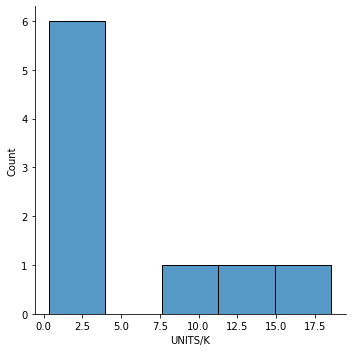

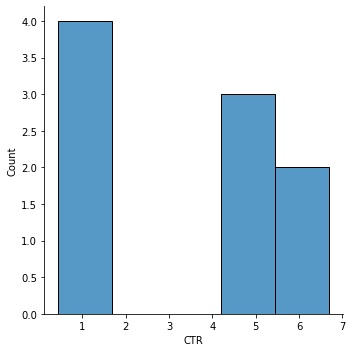

In [30]:
sns.displot(temp, x = "UNITS/K")
sns.displot(temp, x = "CTR")

(array([1.2423e+04, 4.8000e+01, 1.2000e+01, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([   0.,  350.,  700., 1050., 1400., 1750., 2100., 2450., 2800.,
        3150., 3500.]),
 <BarContainer object of 10 artists>)

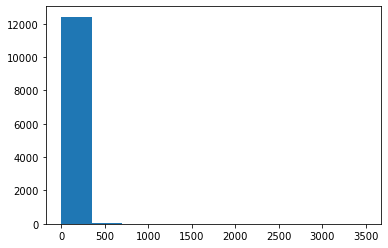

In [31]:
plt.hist(x= data['UNITS/K'])

(array([1.2163e+04, 1.8900e+02, 8.7000e+01, 1.0000e+01, 0.0000e+00,
        4.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <BarContainer object of 10 artists>)

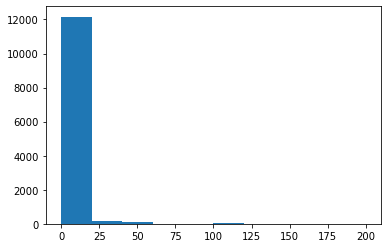

In [32]:
plt.hist(x= data['CTR'])

---